To write this script I based a lot of the code upon the following script of Wim Vranken:
***mapPredsToMSA.py***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
def readMSA(file):
    """
    Reads MSA file in fasta format and return dictionary:
        key: protein ID
        value: gabbed sequence
    """
    with open(file) as f:
        lines = [line.strip() for line in f.readlines()]
    msa=dict()
    for line in lines:
        if line.startswith(">"):
            # generate new key for new proteinId
            Id=line.replace(">","")
            msa[Id]=""
        else:
            # add sequence to entry
            msa[Id]+=line
    return msa

def readPredictions(file):
    """
    Reads prediction file and returns dictionary
        key: protein ID
        value: list of predictions
    """
    with open(file) as f:
        # Strip lines and leave out empty lines
        lines = [line.strip() for line in f.readlines() if len(line.strip())>0]
    predictions=dict()
    for line in lines:
        if line.startswith("* for "):
            # Extract Id from header and assign to dictionary
            Id=line.replace("* for ","").replace(" ","").replace("*","")
            predictions[Id]=list()
        elif line.startswith("*"):
            # Skip lines of the headers
            pass
        else:
            residue, pred_raw = line.replace(" ","").split("\t")
            pred=float(pred_raw)
            predictions[Id].append((residue,pred))
    return predictions

def mapPredictions(predictions, msa):
    """
    Uses predictions dictionary and msa dictionary as input and returns mapped predictions dictionary:
        key:protein ID
        value: mapped prediction
    """
    def map(gabbedSequence, predictionSequence, gab="-"):
        """
        Map one gabbed MSA sequence to a prediction sequence.
            Returns mapped prediction sequence with np.nan values at the gabs
        """
        if len(gabbedSequence.replace(gab,""))!=len(predictionSequence):
            print("There is an unequal amount of predictions and residues in the MSA")
            raise
        # dummy so that there is no out of range ERROR
        predictionSequence=predictionSequence[:]+[("dummy","dummy")]
        """This list will be filled up:
            * a prediction value if there is a residue at the position
            * np.nan value if there is no residue """
        gabbedPredictionSequence=list()
        """Integer of where we are in prediction Sequence
        Everytime we encounter a residue in the MSA sequence, this value will go up with one"""
        iPredictionSequence=0
        for res in gabbedSequence:
            predictionRes=predictionSequence[iPredictionSequence][0]
            predictionValue=predictionSequence[iPredictionSequence][1]
            if res==gab:
                """Gabs are mapped to np.nan values"""
                gabbedPredictionSequence.append(np.nan)
            elif res!=predictionRes:
                print("residue of prediction and residue in MSA should be the same")
                raise
            else:
                """Residues are mapped to there prediction"""
                gabbedPredictionSequence.append(predictionValue)
                iPredictionSequence+=1
        return gabbedPredictionSequence
    
    """Identifieres in MSA and predictions should be the same:
        Mapping will only happen for those Identifiers that occur in both the MSA and prediction set"""
    predictionIds = set(predictions.keys())
    msaIds = set(msa.keys())
    if msaIds!=predictionIds:
        print("""provided protein IDs for MSA not the same as IDs for predictions, 
              taking the intersection of both sets""")
        ids=sorted(predictionIds&msaIds)
    else:
        ids=sorted(msaIds)
    mappedPredictions=dict()
    for Id in ids:
        msaSequence=msa[Id]
        predictionSequence=predictions[Id]
        mappedPredictions[Id]=dict()
        mappedPredictions[Id]["msa"]=msaSequence
        mappedPredictions[Id]["prediction"]=map(msaSequence,predictionSequence)
    return mappedPredictions

def addStatistics(mappedPredictions):
    """This functions looks at the mapped predictions and add statistical information for every column
        * lower quartile
        * median
        * upper quartile
        * IQR
    """
    def generatePredictionArray():
        """concatenates all the sequences into 2D array
            Rows: different sequences
            Columns: different positions"""
        listOfLists=list()
        for Id in mappedPredictions.keys():
            listOfLists.append(mappedPredictions[Id]["prediction"])
        return np.array(listOfLists)
    def extractColumn(predictionArray, column):
        """takes the specified column out of the prediction array and returns it as a list"""
        return list(predictionArray[:,column])
    def calculatePercentile(columnList, percentile, minimalObservations=5):
        """Takes columnList and returns percentile
            Need at least 5 observations"""
        nonNanValues=np.count_nonzero(~np.isnan(columnList))
        if nonNanValues>=minimalObservations:
            return np.nanpercentile(columnList,percentile)
        else:
            return np.nan
    def calculateStd(columnList):
        return np.nanstd(columnList)
    def calculateMean(columnList):
        return np.nanmean(columnList)
    
    predictionArray=generatePredictionArray()
    lowerQuartile=list()
    median=list()
    upperQuartile=list()
    std=list()
    mean=list()
    for column in range(len(predictionArray[0,:])):
        columnList = extractColumn(predictionArray,column)
        lowerQuartile.append(calculatePercentile(columnList,25))
        median.append(calculatePercentile(columnList,50))
        upperQuartile.append(calculatePercentile(columnList,75))
        std.append(calculateStd(columnList))
        mean.append(calculateMean(columnList))
    IQR = list((np.array(upperQuartile)-np.array(lowerQuartile))*1.5)
    """In a norman distribution 75 of observation are between mean +- 0.675"""
    lowerStd = list(np.array(mean)-np.array(std)*0.675)
    upperStd = list(np.array(mean)+np.array(std)*0.675)
    mappedPredictions["stats"]=dict()
    mappedPredictions["stats"]["Q1"]=lowerQuartile
    mappedPredictions["stats"]["median"]=median
    mappedPredictions["stats"]["Q3"]=upperQuartile
    mappedPredictions["stats"]["IQR"]=IQR
    mappedPredictions["stats"]["lower"]=lowerStd
    mappedPredictions["stats"]["mean"]=mean
    mappedPredictions["stats"]["upper"]=upperStd
    return mappedPredictions
    

In [2]:

MSA_FILE="../2020-04-04.FindTwinsWithStructure/4.7.clustalOmega/Q8XBI9.MSA.fasta"
SPECIAL_ID = MSA_FILE.split("/")[-1].split(".")[0]
MSA=readMSA(MSA_FILE)
PREDICTIONS_FILE="../2020-04-20.efoldMinePrediction/WithStructure/{0}/{0}_backbone.pred".format(SPECIAL_ID)
PREDICTIONS=readPredictions(PREDICTIONS_FILE)
PREDICTIONS_MAPPED=mapPredictions(PREDICTIONS,MSA)
PREDICTIONS_MAPPED_STATISTICS = addStatistics(PREDICTIONS_MAPPED)

In [3]:
""" Code check whether every gab is mapped to np.nan value """
MAPPING_CORRECT=True
for ID in [KEY for KEY in PREDICTIONS_MAPPED.keys() if KEY!="stats"]:
    MSA=PREDICTIONS_MAPPED[ID]["msa"]
    MAPPED_PREDICTION=PREDICTIONS_MAPPED[ID]["prediction"]
    for I,RES in enumerate(MSA):
        PRED = MAPPED_PREDICTION[I]
        if RES=="-":
            if not np.isnan(PRED):
                #print(type(PRED),type(RES))
                MAPPING_CORRECT=False
        if np.isnan(PRED):
            if RES!="-":
                #print(type(PRED),type(RES))
                MAPPING_CORRECT=False
MAPPING_CORRECT

True

In [4]:
"""
Code that checks whether np.nan values are ignored when calculating:
    * lower quartile
    * median
    * upper quartile
    * IQR
"""

TEST_VALUES=np.array([
    [2,2,3,4],
    [1,2,3,4],
    [np.nan,5,6,np.nan],
    [7,8,np.nan,np.nan],
    [20,10,11,12],
    [13,np.nan,14,15],
    [16,17,18,np.nan],
    [16,17,18,np.nan],
    [16,17,18,np.nan],
    [np.nan,np.nan,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan],
    [np.nan,np.nan,np.nan,np.nan],
])

TEST=list(TEST_VALUES[:,0])
print(TEST,"\n")
print("median: ", np.nanmedian(TEST)==13)
print(np.nanpercentile(TEST,25))

[2.0, 1.0, nan, 7.0, 20.0, 13.0, 16.0, 16.0, 16.0, nan, nan, nan, nan, nan, nan] 

median:  False
5.75


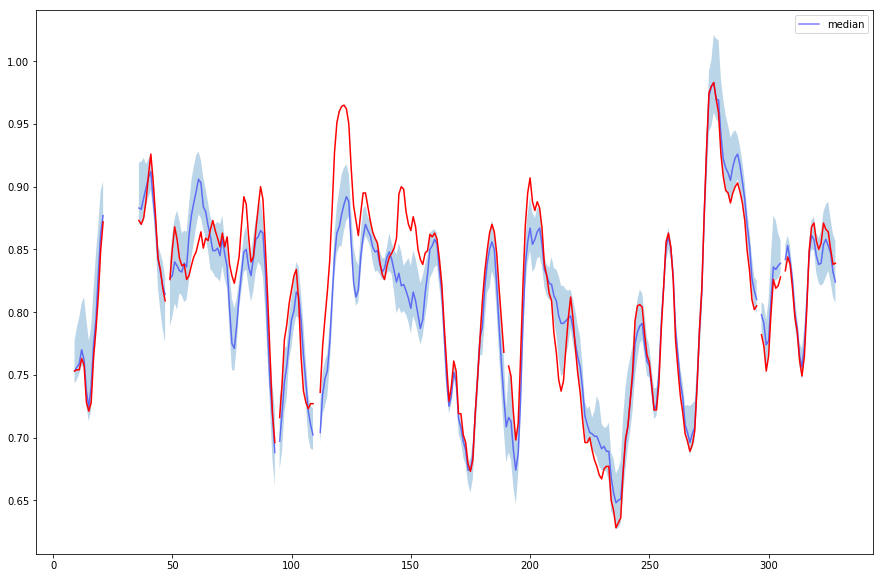

In [5]:
%matplotlib inline
"""
Trying to plot the statistics
"""
plt.figure(figsize=(15,10))
plt.fill_between(range(len(PREDICTIONS_MAPPED_STATISTICS["stats"]["Q1"])),
                PREDICTIONS_MAPPED_STATISTICS["stats"]["Q1"],
                PREDICTIONS_MAPPED_STATISTICS["stats"]["Q3"],
                alpha=0.3)
plt.plot(PREDICTIONS_MAPPED_STATISTICS["stats"]["median"], label="median", color="Blue", alpha=0.5)
plt.plot(PREDICTIONS_MAPPED_STATISTICS[SPECIAL_ID]["prediction"], color="red")
#plt.plot(PREDICTIONS_MAPPED_STATISTICS["stats"]["lower"],label="lower")
#plt.plot(PREDICTIONS_MAPPED_STATISTICS["stats"]["mean"])
#plt.plot(PREDICTIONS_MAPPED_STATISTICS["stats"]["upper"], label="upper")
plt.legend()
plt.show()